## Sentiment Analysis: Yelp Restaurants Reviews

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
import json

import os
from collections import Counter
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

# import the garbage collection
import gc

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

#Set maximum number of rows,columns to be shown. Maximum column width made to 500.
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.notebook_repr_html', True)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir("C:\Master\PD_Career\Courses\Springboard\Capstone Project 2")

#data directory
data_path = "yelp-datasets/"
intermediate_data_path = "yelp-datasets/intermediate/"
source_data_path = "yelp-datasets/source/"
submit_data_path = "yelp-datasets/submit/"

## Data Preview
First, We will preview the datasets by exploring how the data is stored in the source files. <br>.

In [3]:
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    print(business_json_file.readline())

{"business_id":"1SWheh84yJXfytovILXOAQ","name":"Arizona Biltmore Golf Club","address":"2818 E Camino Acequia Drive","city":"Phoenix","state":"AZ","postal_code":"85016","latitude":33.5221425,"longitude":-112.0184807,"stars":3.0,"review_count":5,"is_open":0,"attributes":{"GoodForKids":"False"},"categories":"Golf, Active Life","hours":null}



In [4]:
with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
    print(review_json_file.readline())

{"review_id":"Q1sbwvVQXV2734tPgoKj4Q","user_id":"hG7b0MtEbXx5QzbzE6C_VA","business_id":"ujmEBvifdJM6h6RLv4wQIg","stars":1.0,"useful":6,"funny":1,"cool":0,"text":"Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.","date":"2013-05-07 04:34:36"}



From the below two previews, it is evident that each row of the dataset is stored in json format. <br>
Let's look at a few business categories to check the types of establishments in yelp dataset. <br>
We will also be devising few categories for restaurants we would like to study further in the project. <br> 

In [5]:
# Preview few categories for the business json
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 1000:
            break
        else:
            business_record = json.loads(business_json)
            print(business_record[u'categories'])

Golf, Active Life
Specialty Food, Restaurants, Dim Sum, Imported Food, Food, Chinese, Ethnic Food, Seafood
Sushi Bars, Restaurants, Japanese
Insurance, Financial Services
Plumbing, Shopping, Local Services, Home Services, Kitchen & Bath, Home & Garden, Water Heater Installation/Repair
Shipping Centers, Couriers & Delivery Services, Local Services, Printing Services
Beauty & Spas, Hair Salons
Hair Salons, Hair Stylists, Barbers, Men's Hair Salons, Cosmetics & Beauty Supply, Shopping, Beauty & Spas
Nail Salons, Beauty & Spas, Day Spas
Beauty & Spas, Nail Salons, Day Spas, Massage
Local Services, Professional Services, Computers, Shopping, Home Services, IT Services & Computer Repair, Internet Service Providers, Web Design
Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food
Bars, Nightlife, Pubs, Barbers, Beauty & Spas, Irish Pub
Italian, Restaurants, Pizza, Chicken Wings
Bakeries, Food
Fitness & Instruction, Active Life, Yoga
Hair Stylists, Beauty & Spas, Hair Salons, Men

Waxing, Eyelash Service, Beauty & Spas, Hair Removal, Skin Care
Cocktail Bars, Italian, American (New), Nightlife, Bars, Pizza, Restaurants
Day Spas, Hair Salons, Beauty & Spas
Delis, Restaurants, Sandwiches, Pizza
Restaurants, Italian, Pizza
Post Offices, Notaries, Shipping Centers, Local Services, Mailbox Centers, Printing Services, Public Services & Government
Foundation Repair, Contractors, Waterproofing, Home Services
Education, Middle Schools & High Schools
Vietnamese, Restaurants
Food, Breakfast & Brunch, Ice Cream & Frozen Yogurt, Mexican, Cafes, Restaurants
Walking Tours, Tours, Hotels & Travel
Home Services, Professional Services, Real Estate, Real Estate Agents, Real Estate Services
Fruits & Veggies, Delis, Restaurants, Bakeries, Specialty Food, Farms, Arts & Entertainment, Food
Home Services, Mortgage Brokers, Real Estate
Hair Salons, Nail Salons, Beauty & Spas, Makeup Artists, Day Spas, Eyelash Service
Auto Repair, Car Dealers, Auto Detailing, Body Shops, Automotive
Tree S

<b>Analysis</b><br>
Based on sample 1000 categories, we notice that many establishments have multiple categories. <br>
The establishments with the folloiwng three categories seem to best match the restaurants: (1) Restaurants, (2) Bakeries, (3) Juice Bars
(4) Cafes. <br> 
Hence, we will gather reviews for all the establishments that are in at least one of above categories. 
All other reviews will be outside the scope of our project.<br>

<b>Prototype </b>
For the prototype, we will look for all restaurants within top 50000 business establishments.

In [3]:
restaurant_id_set = set()
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 50000:
            break
        else:
            business_record = json.loads(business_json)
            
            #Check whether the business is a restaurant
            if business_record[u'categories'] is not None:
                if u'restaurants' in business_record[u'categories'].lower() \
                or u'bakeries' in business_record[u'categories'].lower() \
                or u'juice bars' in business_record[u'categories'].lower():
                    #print(business_record[u'categories'])
                    restaurant_id_set.add(business_record[u'business_id'])
                else:                    
                    continue            
                

In [4]:
print(len(restaurant_id_set))
restaurant_id_set = frozenset(restaurant_id_set)

15989


We will consider reviews of these 16000 establishments in restaurant category. <br>
The restaurant_id_set was converted to a frozenset so that it can't be accidentally modified. <br>

<b>Classification</b>
Collecting the files for classification <br>
(1) Look through firdt 200,000 reviews and collect positive and negative reviews.

In [5]:
## Collect reviews for the restaurants in the set
## Data Preparation
if True:
    review_count=0
    
    # Write the reviews in text format. 
    with open(intermediate_data_path+"yelp_restaurants_reviews_classification.txt", 'w' ,encoding='utf_8') as review_txt_file:
        with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
            for line_no, review_json in enumerate(review_json_file):
                if line_no > 200000:
                    break
                else:
                    review_record=json.loads(review_json)

                    #Check if the review is about a restaurant
                    if review_record[u'business_id'] not in restaurant_id_set or int(review_record[u'stars'])==3 :
                        continue
                    #Write restaurant review as a line in the new file
                    #escape new line characters in the original review file
                    if int(review_record[u'stars']) in [4,5]:
                        review='P'
                    else:
                        review='N'
                    
                    review_txt_file.write(str(int(review_record[u'stars'])) + '#$#' + review + '#$#' + review_record[u'text'].replace('\n', '\\n')+'\n')
                    review_count+=1
    print("Total number of reviews: ", review_count) 

Total number of reviews:  112662


In [6]:
gc.collect()

91

# Classifier

In [15]:
reviews_source=pd.DataFrame()
ratings=[]
reviews_text=[]
with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_classification_rev.txt") ,"r", encoding='utf_8') as fin:
    for line_no, line in enumerate(fin):
        if line_no >= 10000:
            break
        else:
            #print(line_no)
            text = line.strip().split('#$#')
            if text[1]=='P':
                rating_val=1
            else:
                rating_val=0
            ratings.append(rating_val)    
            reviews_text.append(text[2].replace('\\n', '\n'))
reviews_source['rating']= ratings
reviews_source['text']= reviews_text
print("Total Number of Reviews:",reviews_source.shape)

Total Number of Reviews: (10000, 2)


In [17]:
#del ratings
#del reviews_text
gc.collect()

87

Preview the dataframe. Rating = 1 means the review is positive and Rating = 0 means the review is negative. 

In [16]:
reviews_source.head(5)

,rating,text
0,1,"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!"
1,1,"I'll be the first to admit that I was not excited about going to La Tavolta. Being a food snob, when a group of friends suggested we go for dinner I looked online at the menu and to me there was nothing special and it seemed overpriced. Im also not big on ordering pasta when I go out. Alas, I was outnumbered. Thank goodness! I ordered the sea bass special. It was to die for. Cooked perfectly, seasoned perfectly, perfect portion. I can not say enough good things about this dish. When the ser..."
2,0,"This place has gone down hill. Clearly they have cut back on staff and food quality\n\nMany of the reviews were written before the menu changed. I've been going for years and the food quality has gone down hill.\n\nThe service is slow & my salad, which was $15, was as bad as it gets.\n\nIt's just not worth spending the money on this place when there are so many other options."
3,1,"Like walking back in time, every Saturday morning my sister and I was in a bowling league and after we were done, we'd spend a few quarters playing the pin ball machines until our mother came to pick us up.\n\nMy sister was daring and play the machines hard, she was afraid of that ""tilt"" showing up and freezing the game. I, on the other hand was a bit more gentler and wanted to make sure I got my quarter's worth.\n\nThis place has rows and rows of machines, some are really old and some are ..."
4,0,"Walked in around 4 on a Friday afternoon, we sat at a table just off the bar and walked out after 5 min or so. Don't even think they realized we walked in. However everyone at the bar noticed we walked in!!! Service was non existent at best. Not a good way for a new business to start out. Oh well, the location they are at has been about 5 different things over the past several years, so they will just be added to the list. SMDH!!!"


In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
# Create the count vectorizer dataset
def create_datasets(reviews, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews.text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = reviews['rating'].values
    return X, y

In [43]:
X, y = create_datasets(reviews_source)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Training Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
print('NB Accuracy on training dataset', nb_classifier.score(X_train,y_train))
print('NB Accuracy on test dataset', nb_classifier.score(X_test,y_test))

NB Accuracy on training dataset 0.9604285714285714
NB Accuracy on test dataset 0.923


Baseline Performance of Naive Bayes Model: 92.3 % <br>
Next, we will improve the classifer in the hope to improve the model <br>

Text(0, 0.5, 'CDF: Cummulative DF')

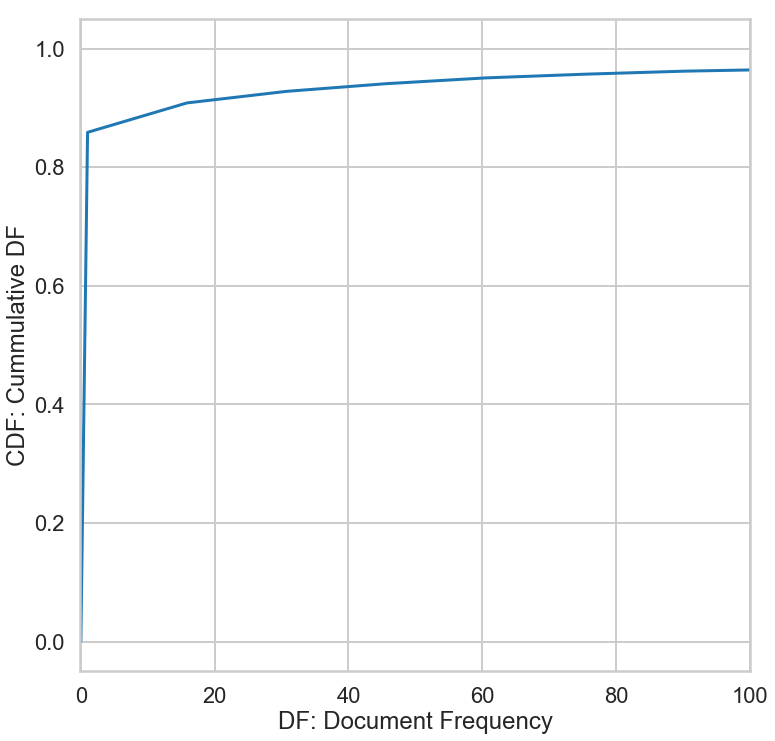

In [31]:
# Choosing appropriate values of min_df and max_df
fig, ax = plt.subplots(figsize=(12,12))
df = list(sorted((X > 0).sum(axis=0).reshape(-1).tolist()[0]))
rows, features = X.shape
height, axis = np.histogram(df, bins=len(np.unique(df)))
cumhist = np.cumsum(height * 1, axis=0) / features
axis = np.insert(axis, 0, 0)
cumhist = np.insert(cumhist, 0, 0)
plt.plot(axis[:-1], cumhist)
plt.xlim(-.1, 100)
plt.xlabel("DF: Document Frequency")
plt.ylabel("CDF: Cummulative DF")

Text(0, 0.5, 'CDF: Cummulative DF')

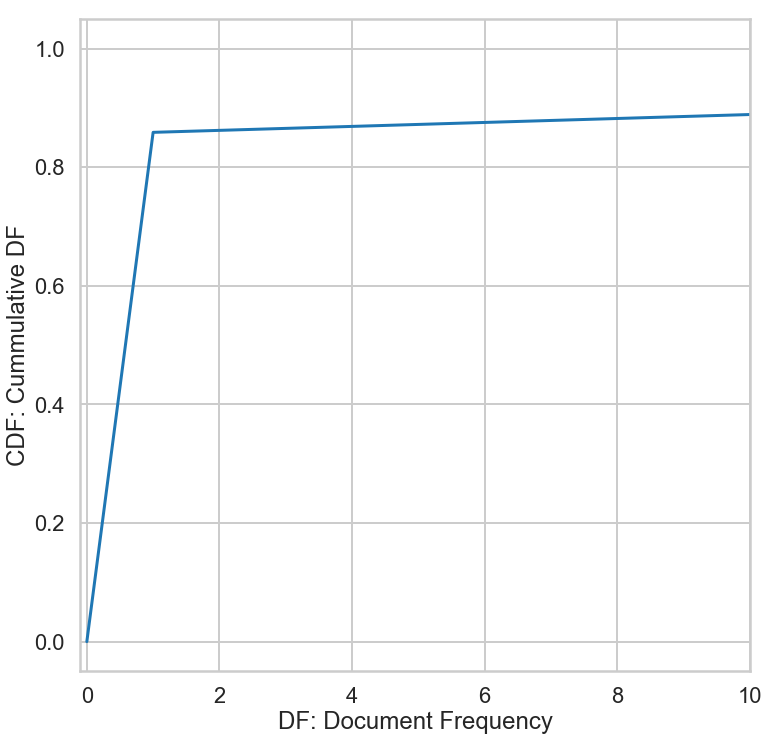

In [32]:
# Choosing a different range: 0 to 10
# Choosing appropriate values of min_df and max_df
fig, ax = plt.subplots(figsize=(12,12))
df = list(sorted((X > 0).sum(axis=0).reshape(-1).tolist()[0]))
rows, features = X.shape
height, axis = np.histogram(df, bins=len(np.unique(df)))
cumhist = np.cumsum(height * 1, axis=0) / features
axis = np.insert(axis, 0, 0)
cumhist = np.insert(cumhist, 0, 0)
plt.plot(axis[:-1], cumhist)
plt.xlim(-.1, 10)
plt.xlabel("DF: Document Frequency")
plt.ylabel("CDF: Cummulative DF")

In [33]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [34]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    neg = y == 0
    pos = ~neg
    return prob[neg, 0].sum() + prob[pos, 1].sum()

In [36]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(reviews_source.shape[0]), test_size=0.3, random_state=42)
mask = np.zeros(reviews_source.shape[0], dtype=np.bool)
mask[itest] = True

In [49]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [0.01, .1, 1, 5, 10, 50]

best_min_df = 0.01 # YOUR TURN: put your value of min_df here.

min_dfs=[10, 1, 0.1, 0.01, 0.001, 0.0001]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = create_datasets(reviews_source,vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        model = MultinomialNB(alpha=alpha)
        score = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)

alpha:  0.01  min_df:  10  score: -638.1030025581509
alpha:  0.01  min_df:  1  score: -696.3201154608557
alpha:  0.01  min_df:  0.1  score: -267.0198223059009
alpha:  0.01  min_df:  0.01  score: -350.1619314832131
alpha:  0.01  min_df:  0.001  score: -638.1030025581509
alpha:  0.01  min_df:  0.0001  score: -696.3201154608557
alpha:  0.1  min_df:  10  score: -462.09219403997594
alpha:  0.1  min_df:  1  score: -495.39695677562815
alpha:  0.1  min_df:  0.1  score: -267.00249688815654
alpha:  0.1  min_df:  0.01  score: -343.4996190818034
alpha:  0.1  min_df:  0.001  score: -462.09219403997594
alpha:  0.1  min_df:  0.0001  score: -495.39695677562815
alpha:  1  min_df:  10  score: -361.6789137113459
alpha:  1  min_df:  1  score: -668.1800711941944
alpha:  1  min_df:  0.1  score: -266.8278747080613
alpha:  1  min_df:  0.01  score: -330.9879158664083
alpha:  1  min_df:  0.001  score: -361.6789137113459
alpha:  1  min_df:  0.0001  score: -668.1800711941944
alpha:  5  min_df:  10  score: -414.23

In [50]:
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

Best score: -253.5335620308246
Best alpha: 50
Best min_df: 0.1


Now, we try another iteration to find whether the hyperparameters can still be better

In [51]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [40, 45,50,60,70,100]
best_min_df = 0.01 # YOUR TURN: put your value of min_df here.

min_dfs=[0.07, 0.08, 0.09, 0.1, 0.11, 0.12]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = create_datasets(reviews_source,vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        model = MultinomialNB(alpha=alpha)
        score = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)

alpha:  40  min_df:  0.07  score: -271.44681001911226
alpha:  40  min_df:  0.08  score: -271.0663572083171
alpha:  40  min_df:  0.09  score: -264.0652890085382
alpha:  40  min_df:  0.1  score: -256.1515331808632
alpha:  40  min_df:  0.11  score: -258.87683325449535
alpha:  40  min_df:  0.12  score: -260.21485100331506
alpha:  45  min_df:  0.07  score: -269.99111654871126
alpha:  45  min_df:  0.08  score: -269.59362035784227
alpha:  45  min_df:  0.09  score: -262.61835513321205
alpha:  45  min_df:  0.1  score: -254.78041811182712
alpha:  45  min_df:  0.11  score: -257.64055556993515
alpha:  45  min_df:  0.12  score: -259.2129021041912
alpha:  50  min_df:  0.07  score: -268.98022665492
alpha:  50  min_df:  0.08  score: -268.424088855881
alpha:  50  min_df:  0.09  score: -261.33527621046574
alpha:  50  min_df:  0.1  score: -253.5335620308246
alpha:  50  min_df:  0.11  score: -256.47549901491794
alpha:  50  min_df:  0.12  score: -258.2425258640601
alpha:  60  min_df:  0.07  score: -268.486

In [52]:
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

Best score: -250.3031429829295
Best alpha: 70
Best min_df: 0.1


In [53]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [70,75,80,85,90]
best_min_df = 0.01 # YOUR TURN: put your value of min_df here.

min_dfs=[0.1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = create_datasets(reviews_source,vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        model = MultinomialNB(alpha=alpha)
        score = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)

alpha:  70  min_df:  0.1  score: -250.3031429829295
alpha:  75  min_df:  0.1  score: -250.04629731608188
alpha:  80  min_df:  0.1  score: -250.05163517857585
alpha:  85  min_df:  0.1  score: -250.33616368008643
alpha:  90  min_df:  0.1  score: -250.91016774258733


In [54]:
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

Best score: -250.04629731608188
Best alpha: 75
Best min_df: 0.1


In [57]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = create_datasets(reviews_source, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.844333
Accuracy on test data:     0.833429


In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[ 931  714]
 [ 452 4903]]


<b> Analysis </b>
We can see both the accuracy on training data as wells as testing data decrease. However, this model generalized well as br>
there is less difference between the score on training and the test dataset. <br>

# Strong Predictive Features
Next,  Lets look at a few strongly predictive features available in positive reviews and negative reviews respectively.

In [59]:
# Strong Predictive Features
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

In [60]:
# List of top 20 words predicting Negative Reviews
print("Good words\t     P(Positive | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(Positive | word)
               great 0.91
             amazing 0.90
           delicious 0.90
            friendly 0.87
                best 0.86
                love 0.86
          definitely 0.86
              always 0.85
               fresh 0.85
                  is 0.84
                nice 0.83
                very 0.83
                 are 0.83
                also 0.83
                good 0.83
                with 0.82
                well 0.82
          everything 0.81
                 try 0.81
               their 0.81


In [61]:
# List of top 20 words predicting Negative (Not Positive) Reviews
print("Bad words\t     P(Positive | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Bad words	     P(Positive | word)
                them 0.69
                what 0.69
               would 0.68
                  up 0.68
                  at 0.68
                  me 0.68
                 don 0.67
                  us 0.66
                came 0.66
             because 0.66
             ordered 0.66
                 not 0.66
               order 0.66
                over 0.64
                didn 0.64
                  do 0.64
                even 0.64
               after 0.62
               never 0.60
                  no 0.56


# Prediction Error

In [ ]:
x, y = create_datasets(reviews_source, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)


In [66]:
mis_pred_bad_reviews = np.argsort(prob[y == 0])[:5]

print("Actually Negative Reviews, Predicted as Positive Reviews")
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('\n')
for row in mis_pred_bad_reviews:
    print("-------------------------------------------------------")
    print(reviews_source[y == 0].text.iloc[row])
    print("")

Actually Negative Reviews, Predicted as Positive Reviews
------------------------------------------------------------
------------------------------------------------------------


-------------------------------------------------------
*2.5 stars* Extra 0.5 star for the tasting menu- great deal, I must say.

My dinner date and I came here on a Saturday night after hearing and reading all the buzz online and seeing all the pictures.  We made reservations for about 8:30, and was empty except for a rather large party in the back (which actually knows the staff, I think).  Definitely not what you expect on a weekend night at a new and  supposedly trendy place. 

My date is Filipino himself and knows all the traditional flavours, and I have been out to some more traditional Filipino restaurants around the city.  So we're both quite familiar with the cuisine, but the dishes here are served with a modern twist, and we were excited! The menu is nice and concise consisting of a snacks/apps sec

In [67]:
mis_pred_good_reviews = np.argsort(prob[y == 1])[-5:]

print("Actually Positive Reviews, Predicted as Negative Reviews")
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('\n')
for row in mis_pred_good_reviews:
    print("-------------------------------------------------------")
    print(reviews_source[y == 1].text.iloc[row])
    print("")

Actually Positive Reviews, Predicted as Negative Reviews
------------------------------------------------------------
------------------------------------------------------------


-------------------------------------------------------
A week and a half ago, I took my beau to Port. I wanted a restaurant that he's never been to, with an awesome patio view seeing as he's a Summer baby. I've been to Port on 3 other occasions but never for dinner. I had went for brunch, drinks and even appetizers so the dinner experience was something I anticipated.

I called in for reservations for 7:15 and they told me they could do 7:45. No biggie at all. I'd rather show up and have a table ready then go to the restaurant and have to wait out an available table. I mentioned it was my dude's birthday and I really wanted a patio table but on the website it does clearly state that they do not take reservations for the patio and it's first-come-first-serve. The hostess on the phone said she will note that 

# Improvements Over the Base Classifier


In [68]:
x=['This restaurant is not great, or superb in any way']
clf.predict_proba(vectorizer.transform(x))[0][1]

0.872590737385785

<b> Analysis </b> <br>
The above review was negative, still it was considered as a positive review because of keywords: great, superb <br>
that will typically be found in good reviews <br> 

# TF-IDF Vectorizer
Then, We try a TD-IDF vectorizer

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(reviews_source.text)

In [70]:
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))
X, y = create_datasets(reviews_source, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha)
clf.fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.764667
Accuracy on test data:     0.765000


In [71]:
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1, 3))
X, y = create_datasets(reviews_source, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha)
clf.fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.764667
Accuracy on test data:     0.765000


# Hyperparameter Tuning
Now, lets find the best hyper parameters for the tf-idf model


In [72]:
#the grid of parameters to search over
alphas = [0.01, .1, 1, 5, 10, 50]
best_min_df = 0.01 # YOUR TURN: put your value of min_df here.

min_dfs=[10, 1, 0.1, 0.01, 0.001, 0.0001]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        tfidfvectorizer = TfidfVectorizer(min_df=min_df, stop_words='english', ngram_range=(1, 3))       
        Xthis, ythis = create_datasets(reviews_source,tfidfvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        model = MultinomialNB(alpha=alpha)
        score = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)

alpha:  0.01  min_df:  10  score: -153.11044786132894
alpha:  0.01  min_df:  1  score: -463.2073889107219
alpha:  0.01  min_df:  0.1  score: -256.0343386466201
alpha:  0.01  min_df:  0.01  score: -166.56697749466184
alpha:  0.01  min_df:  0.001  score: -153.11044786132894
alpha:  0.01  min_df:  0.0001  score: -463.2073889107219
alpha:  0.1  min_df:  10  score: -135.59236206654245
alpha:  0.1  min_df:  1  score: -242.72042341616938
alpha:  0.1  min_df:  0.1  score: -256.1651256970523
alpha:  0.1  min_df:  0.01  score: -167.22077695463727
alpha:  0.1  min_df:  0.001  score: -135.59236206654245
alpha:  0.1  min_df:  0.0001  score: -242.72042341616938
alpha:  1  min_df:  10  score: -205.3427162385173
alpha:  1  min_df:  1  score: -320.3468127373984
alpha:  1  min_df:  0.1  score: -257.44259764220817
alpha:  1  min_df:  0.01  score: -180.94003958247794
alpha:  1  min_df:  0.001  score: -205.3427162385173
alpha:  1  min_df:  0.0001  score: -320.3468127373984
alpha:  5  min_df:  10  score: -2

In [73]:
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

Best score: -135.59236206654245
Best alpha: 0.1
Best min_df: 10


In [75]:
#the grid of parameters to search over
alphas = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12]
best_min_df = 0.01 # YOUR TURN: put your value of min_df here.

min_dfs=[5,10,15,20,50,100]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        tfidfvectorizer = TfidfVectorizer(min_df=min_df, stop_words='english', ngram_range=(1, 3))       
        Xthis, ythis = create_datasets(reviews_source,tfidfvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        model = MultinomialNB(alpha=alpha)
        score = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        #print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

Best score: -134.35265461303194
Best alpha: 0.07
Best min_df: 10


In [76]:
#the grid of parameters to search over
alphas = [0.05, 0.06, 0.07]
best_min_df = 0.01 # YOUR TURN: put your value of min_df here.

min_dfs=[10]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        tfidfvectorizer = TfidfVectorizer(min_df=min_df, stop_words='english', ngram_range=(1, 3))       
        Xthis, ythis = create_datasets(reviews_source,tfidfvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        model = MultinomialNB(alpha=alpha)
        score = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        #print('alpha: ', alpha, ' min_df: ', min_df, ' score:', score)
print("Best score: {}".format(maxscore))
print("Best alpha: {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))

Best score: -134.30572760544396
Best alpha: 0.06
Best min_df: 10


# Best Model Performance

In [77]:
vectorizer = TfidfVectorizer(min_df=best_min_df, stop_words='english', ngram_range=(1, 3))
X, y = create_datasets(reviews_source, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.976333
Accuracy on test data:     0.913429


In [80]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1160  485]
 [ 121 5234]]


<b>Analysis</b>
This is a good improvement over the baseline model (8% Increase in Accuracy on Test Dataset)

# Strong Predictive Features
Next,  Lets look at a few strongly predictive features available in positive reviews and negative reviews respectively.

In [81]:
# Strong Predictive Features
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

In [82]:
# List of top 20 words predicting Negative Reviews
print("Good words\t     P(Positive | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(Positive | word)
     definitely come 0.99
                 gem 0.99
    friendly service 0.99
      friendly staff 0.99
               fancy 0.99
             best ve 0.99
         traditional 0.99
   definitely return 0.99
               greek 0.99
          pleasantly 0.99
    great food great 0.99
   reasonably priced 0.99
    highly recommend 0.99
              hidden 0.99
pleasantly surprised 0.99
  highly recommended 0.99
              fluffy 0.99
            enjoying 0.99
    cooked perfectly 0.98
             pricing 0.98


In [83]:
# List of top 20 words predicting Negative (Not Positive) Reviews
print("Bad words\t     P(Positive | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Bad words	     P(Positive | word)
       won returning 0.05
                exit 0.05
         waste money 0.05
       service awful 0.05
           won going 0.05
             food ok 0.04
              subpar 0.04
            lukewarm 0.04
      unprofessional 0.04
        unacceptable 0.04
          complained 0.04
    horrible service 0.04
           poisoning 0.04
      food poisoning 0.04
    terrible service 0.04
       mediocre best 0.04
             ignored 0.03
         avoid place 0.03
           tasteless 0.03
               stale 0.03


<b> Analysis </b> <br>
From the keywords, it is clear to identify the words that are top features for positive as well as negative reviews. <br>

# Prediction Errors


In [84]:
x, y = create_datasets(reviews_source, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

In [85]:
mis_pred_bad_reviews = np.argsort(prob[y == 0])[:5]

print("Actually Negative Reviews, Predicted as Positive Reviews")
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('\n')
for row in mis_pred_bad_reviews:
    print("-------------------------------------------------------")
    print(reviews_source[y == 0].text.iloc[row])
    print("")

Actually Negative Reviews, Predicted as Positive Reviews
------------------------------------------------------------
------------------------------------------------------------


-------------------------------------------------------
*2.5 stars* Extra 0.5 star for the tasting menu- great deal, I must say.

My dinner date and I came here on a Saturday night after hearing and reading all the buzz online and seeing all the pictures.  We made reservations for about 8:30, and was empty except for a rather large party in the back (which actually knows the staff, I think).  Definitely not what you expect on a weekend night at a new and  supposedly trendy place. 

My date is Filipino himself and knows all the traditional flavours, and I have been out to some more traditional Filipino restaurants around the city.  So we're both quite familiar with the cuisine, but the dishes here are served with a modern twist, and we were excited! The menu is nice and concise consisting of a snacks/apps sec

In [86]:
mis_pred_good_reviews = np.argsort(prob[y == 1])[-5:]

print("Actually Positive Reviews, Predicted as Negative Reviews")
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('\n')
for row in mis_pred_good_reviews:
    print("-------------------------------------------------------")
    print(reviews_source[y == 1].text.iloc[row])
    print("")

Actually Positive Reviews, Predicted as Negative Reviews
------------------------------------------------------------
------------------------------------------------------------


-------------------------------------------------------
You know I've been coming here for years now and it's my go to place for a good breakfast burrito. Problem is the service....for the most part it's ok but whenever you call in they almost always put you on hold. Then it's a toss up on how long they leave you there...usually a min 2 mins up to 6 or 7 believe it or not.  Tried this the other day and was put on hold ....waited and waited....6 mins later still no response and I arrived at the location. I asked the server and she said there were only 2 of them and that's why they're told to put people on hold.  

That raises the obvious question...why do you only have 2 servers on an extremely busy Sat morning?...frustrating for customers and got a bit of attitude from the server for good measure....nice!

-

<b> Analysis </b> <br>
All the above reviews appear to be on the border case and depend on the subjecting rating of the users. <br>
I believe it would be good to know how an user usually reviews (mostly gives positive reviews or mostly gives negative reviews) <br>

# Topic Recognition
Topic Recognition using LDA

In this section, we will analyze reviews of few specific seafood restaurants to find topics from their reviews <br>

In [3]:
restaurant_id_set = set()
with open(source_data_path+"yelp_academic_dataset_business.json", encoding='utf_8') as business_json_file:
    for line_no, business_json in enumerate(business_json_file):
        if line_no > 50000:
            break
        else:
            business_record = json.loads(business_json)
            
            #Check whether the business is a restaurant
            if business_record[u'categories'] is not None:
                if u'restaurants' in business_record[u'categories'].lower() \
                and u'seafood' in business_record[u'categories'].lower():
                    #print(business_record[u'categories'])
                    restaurant_id_set.add(business_record[u'business_id'])
                else:                    
                    continue  

In [5]:
gc.collect()

71

In [16]:
## Collect reviews for the restaurants in the set
## Data Preparation
if True:
    review_count=0
    
    # Write the reviews in text format. 
    with open(intermediate_data_path+"yelp_restaurants_reviews_topic_recognition.txt", 'w' ,encoding='utf_8') as review_txt_file:
        with open(source_data_path+"yelp_academic_dataset_review.json", encoding='utf_8') as review_json_file:
            for line_no, review_json in enumerate(review_json_file):
                if line_no > 1500000:
                    break
                else:
                    review_record=json.loads(review_json)

                    #Check if the review is about a restaurant
                    if review_record[u'business_id'] not in restaurant_id_set:
                        continue
                    #Write restaurant review as a line in the new file
                    #escape new line characters in the original review file
                    if int(review_record[u'stars']) in [4,5]:
                        review='P'
                    else:
                        review='N'
                    
                    review_txt_file.write('#$#'.join((str(int(review_record[u'stars'])), review, review_record[u'review_id'], review_record[u'business_id'], review_record[u'user_id'], review_record[u'text'].replace('\n', '\\n')+'\n')))
                    
                    review_count+=1
    print("Total number of reviews: ", review_count) 

Total number of reviews:  74886


Now, lets try to find out find businesses with at least 1000 reviews
Total 74,886 reviews

In [30]:
reviews_source=pd.DataFrame()
ratings=[]
reviews_text=[]
business_ids=[]
user_ids=[]
with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_topic_recognition_rev.txt") ,"r", encoding='utf_8') as fin:
    for line_no, line in enumerate(fin):
        #print(line_no)
        text = line.strip().split('#$#')
        ratings.append(text[1]) 
        business_ids.append(text[3])
        user_ids.append(text[4])
reviews_source['rating']= ratings
reviews_source['business_id']= business_ids
reviews_source['user_id']= user_ids

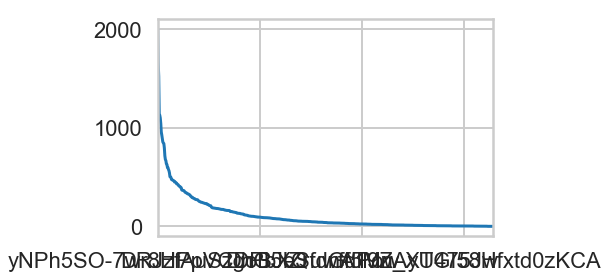

In [31]:
reviews_source['business_id'].value_counts().plot()

In [32]:
reviews_source['business_id'].value_counts()[:20]

yNPh5SO-7wr8HPpVCDPbXQ    2006
u4sTiCzVeIHZY8OlaL346Q    1657
rTS8LsUmNIiXsXydE49tPA    1525
S-oLPRdhlyL5HAknBKTUcQ    1139
T2tEMLpTeSMxLKpxwFdS3g    1129
YRyYbOSwvHkZsZOLv98oQg    1101
vx4YAA02Qz6khRD1fZ1MFA    1046
LYWbyu1EQM2o5hwHG5_Ldg     958
TkEMlu88OZn9TKZyeY9CJg     927
pik4ebdFa0UcUhnNkivFcg     889
6xgcHeLad-VaoTIQewK84A     857
Q7m8G4579-XYKV3LMW8V7g     847
rvnTFEq7R2ZHg0_CYbBNFw     841
p3YqOYELqXtLyHz9T49p_w     796
bjSC_jbrypke0l-bXXBmwQ     716
I-5qHCVwT7k_KH67-YOx3A     679
Ak08F6RqjHYmVCzweBbTrQ     667
ghDNHpqETRJGxG5iUtaZtw     634
STtrEGylaYOXoXQFLP5OAQ     630
XwJ6fZRVbxQYRsryy4-qDw     599
Name: business_id, dtype: int64

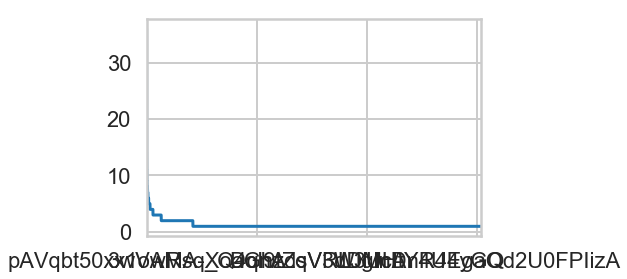

In [33]:
reviews_source['user_id'].value_counts().plot()

In [34]:
reviews_source['user_id'].value_counts()

pAVqbt50xx1owRsq_Q4qnA    36
CxDOIDnH8gp9KXzpBHJYXw    25
PKEzKWv_FktMm2mGPjwd0Q    25
V-BbqKqO8anwplGRx9Q5aQ    24
289XZ50rDG3uEoX263Nnzg    22
Name: user_id, dtype: int64

We will go ahead with topic recognition of business id: yNPh5SO-7wr8HPpVCDPbXQ
For Topic Recognition, we consider ratings 1,2 and 3 as negative review and 4 or 5 as positive review.

In [87]:
def grab_reviews(business_id):
    reviews_df=pd.DataFrame()
    ratings=[]
    reviews_text=[]
    with open( os.path.join(intermediate_data_path,"yelp_restaurants_reviews_topic_recognition_rev.txt") ,"r", encoding='utf_8') as fin:
        for line_no, line in enumerate(fin):
            text = line.strip().split('#$#')
            if text[3] == business_id:
                if text[1]=='P':
                    rating_val=1
                elif text[1]=='M':
                    rating_val=-1
                else:
                    rating_val=0
                ratings.append(rating_val)    
                reviews_text.append(text[5].replace('\\n', '\n'))
    reviews_df['rating']= ratings
    reviews_df['text']= reviews_text
    return reviews_df

In [88]:
bus_reviews=grab_reviews('yNPh5SO-7wr8HPpVCDPbXQ')

In [39]:
bus_reviews

,rating,text
0,1,"First off food is DELICIOUS! By far my favorite restaurant in downtown Phoenix. I have tried so many different things from the menu and it never disappoints, but the Saturday night special Prime Rib and Horseradish Dauphinoise Potato is my favorite. Second, the service is amazing. Ian is my favorite waiter, will request him every time! He is so personable with a good sense of humor! He constantly is checking up to make sure everything is good (but not too much). He made the experience at the..."
1,0,"This is a tricky one. AB is a really cool looking spot, really nice decor and ambiance, comfy booths, it even smells like a new car.\n\nMy group was greeted promptly by smiling hosts, and seated in a nice booth. Drink orders were placed, and when our margaritas arrived, they were really, really off and tasted terrible. Even after stirring, and thinking positive thoughts- they just were off- not sweet enough, and didn't taste good. Our server was cool and he swapped them out for other stuff. ..."
2,1,We got the chicken club and the prime rib dip!!! French fries and side salad!! It was yummy!!!!!!:) Only problem was not a kids menu. They will make a few items for the kids!!! The chicken tenders... The kids did not like them... Not your normal kid friendly kid coating!!!
3,0,"I was not a fan of this location or the staff. The food was sub par, the service was lacking, and overall it was not a good experience. For the amount of $$ per dish I expect it to be prepared better"
4,0,"Our first stop in a wild bachelor party weekend around the Phoenix area. After doing some research for lunch I decided on the arrogant butcher. What a great name for a restaurant located in downtown Phoenix directly across from the Arizona Diamondbacks ball park. With a solid 4 stars and over 1200 reviews it had to be outstanding right? Unfortunately the arrogance overcame the actual experience that we received. Arriving during happy hour the restaurant was extremely dead, but spring break, ..."
5,1,"My husband and I walked in right as the doors opened and were greeted immediately. Everyone was very welcoming and we loved the decor. Our server Tony offered us the daily specials, answered all our questions and even made suggestions. He was extremely knowledgeable and friendly. We had the pretzels with cheese for appetizers. They were the best we've ever had! Our sandwiches were tasty and proportions just the right size. Loved everything! Everyone should give this place a try when downtown..."
6,1,"Great food and service! We ordered the shrimp appetizer and got the pretzels on a kitchen error as well. Both were incredible!\n\nDinner was the burger and beet salad for us. Pro tip: get the burger with bacon, avocado, and a friend egg. Extremely satisfying and filling.\n\nDrinks and food came out quick and the service was great. Anthony checked in with us just the right amount and was quick to get us what we needed.\n\nA great place to stop when downtown - close to the stadiums if going to..."
7,0,"I was reasonably impressed with AB. We got there just before the lunch rush and scored a prime table near the windows (tho upon leaving, my friend noted how cozy the sofa-bench tables looked, so I'll aim for one of those next time). Our server, Robert, made even the soup of the day (tomato bisque) sound out of this world. Even after the restaurant filled up, he was attentive and made sure we enjoyed our meal. \n\nWe shared a handful of oysters with a mild jalapeño sauce. They could have been..."
8,0,It's coo. Kinda expensive. . Nice ambiance. ... does smell like sea food though.... (I don't like seafood lol). . Fish.. super nice staff this far
9,0,We entertained clients there. It's a great location and certainly a trendy night spot. I give kudos to the hostesses for helping us pull together several tables and being patient while we waited for our colleagues to arrive after they got lost.\n\nSort of strange though how we would order drinks from our server

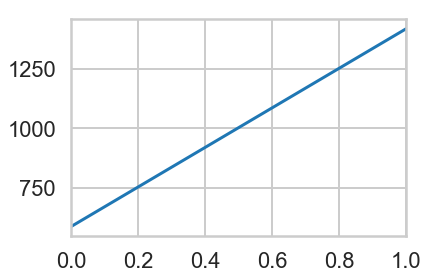

In [41]:
bus_reviews.rating.value_counts().plot()

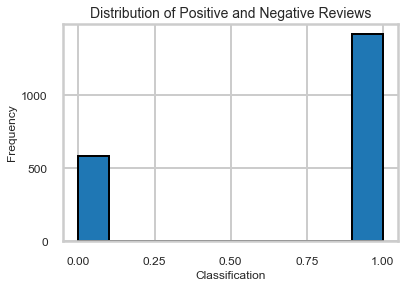

In [46]:
plt.title('Distribution of Positive and Negative Reviews',fontsize=14)
plt.xlabel('Classification',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.hist(bus_reviews['rating'], histtype='bar',ec='black')
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12) 
plt.show()

It is an imbalanced problem.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
no_features = 1000

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

In [50]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(bus_reviews.text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [51]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(bus_reviews.text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [61]:
no_topics = 2

In [62]:
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [71]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf_model, tfidf_feature_names, no_top_words)
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
good just ordered really like cheese place menu restaurant salad
Topic 1:
great food service place atmosphere amazing excellent staff awesome drinks
Topic 0:
pretzel bread cheese good sweet stew salad pudding like caramel
Topic 1:
food good great place service just really ordered time like


In [63]:
no_top_words = 4
no_top_documents = 2

In [64]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [65]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
good just ordered really
I spent four nights in downtown Phoenix at a conference this past week, and I only got out of the depressing conference hotel a few times, for off-campus dinners. On Friday night, I walked over to The Arrogant Butcher with four friends, and we had a nice meal.

This place was actually our second choice, but apparently you can't just walk into Blue Hound on a Friday night and expect to plonk down at a large table. We had passed The Arrogant Butcher on our walk over, and it looked spacious and charming, so we went back. (It later became apparent that everyone from this conference ate at this restaurant at some point or another.) There was a short wait--twenty minutes, if that--which we spent at the wide-open bar. We could've eaten there too if we were a smaller group, but were happy to get a comfortable table at a corner of the restaurant.

I really enjoyed the place. I feel like I've been to a lot of restaurants that might as well be called The Arrogant

In [67]:
display_topics(lda_H, lda_W, tf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
pretzel bread cheese good
Our menu so far: house made pretzels and provolone fondue, sweet potato tortelli, roasted beet salad, montchevre (goat Brie), chicken stroganoff, smoked pork Cubano, turkey pastrami, French fries, a kids grilled ham and cheese sandwich, a kids chicken tenders, the "hot chocolate" cake, and pumpkin cheesecake with pomegranate compote. 

Pretzels: yes, just get them. Perfectly cooked and brined, and that provolone has a flavor something of magic. If you can't go for some German bread paired with Swiss/Italian/French melted cheese, well, that's just un-American. 

Montchevre: still not a fan of goat cheese. My friend liked it quite well, however. 

Roasted beet salad: surprisingly amazing!  I'm not a huge food risk taker, but I do consider myself a foodie, and I'm trying to take more risks with my palette. This was just perfectly combined: roasted beet for a base (first time eating beets, do it here. It was mine, too), Brussel sprouts for depth, pistachi

# Top 2 Topics from Positive and Negative Reviews resepctively

In [72]:
# Positive Reviews
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(bus_reviews.text[bus_reviews.rating==1])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(bus_reviews.text[bus_reviews.rating==1])
tf_feature_names = tf_vectorizer.get_feature_names()

In [73]:
no_topics = 2
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [74]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf_model, tfidf_feature_names, no_top_words)
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
good really ordered cheese just pretzel like menu place butcher
Topic 1:
great food service place atmosphere amazing staff drinks excellent love
Topic 0:
great food good service place really just menu time amazing
Topic 1:
man chile pudding did caramel like salted serve seated orange


In [75]:
no_top_words = 4
no_top_documents = 2

In [76]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [77]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
good really ordered cheese
This was the best food experience we had during our Phoenix vacation. We did not need reservations and were seated right away. Service was excellent; our waiter/server was amazing and very knowledgeable about the menu and the wine selections. They made special accommodations for us to adjust the appetizer we wanted to accommodate our dietary restrictions and we were not disappointed. The beef spare rib stew was delicious and all the other selections were equally satisfying; even my very picky daughter finished her entree. Altogether one of the best culinary experiences I've had in a long time. Kudos!! Would definitely recommend and visit again when in Phoenix.
When I arrived in Arizona. I asked the front desk at the hotel what the best restaurant in town was. Without question they said the Arrogant Butcher. To put it kindly, this restaurant has fantastic decor, but is an upgraded version of Applebee's. The filet was pathetic, the pasta was overcooked

In [78]:
display_topics(lda_H, lda_W, tf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
great food good service
A typical Fox restaurant...good!  I eat lunch here regularly and the food is a steady 8/10 every time.  The short rib stew is excellent as well as the French Dip and I'm a French dip fanatic.  Fries are just slightly "overdone"...just the way I like them.  Servers are always pleasant and attentive.  The only reason this place doesn't get 5 stars from me are the hostesses.  Every time I come here (about 1-2 times a week) the hostess seems confused on where to seat people.  I know it's only a couple minutes but the place can be empty and you're going to wait there while the confused hostess stand figures out where to seat you.
This was the best food experience we had during our Phoenix vacation. We did not need reservations and were seated right away. Service was excellent; our waiter/server was amazing and very knowledgeable about the menu and the wine selections. They made special accommodations for us to adjust the appetizer we wanted to accommodate ou

# Topics from Negative Reviews


In [89]:
# Positive Reviews
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(bus_reviews.text[bus_reviews.rating==0])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(bus_reviews.text[bus_reviews.rating==0])
tf_feature_names = tf_vectorizer.get_feature_names()

In [90]:
no_topics = 2
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [91]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf_model, tfidf_feature_names, no_top_words)
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
food good place just service like time ordered restaurant came
Topic 1:
wait minutes told 15 bar 10 seated 45 min table
Topic 0:
food came place great service ordered dinner like restaurant way
Topic 1:
food good place like just chicken really service great got


In [92]:
no_top_words = 4
no_top_documents = 2

In [93]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [94]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
food good place just
We came in with a party of twenty and the team was great! Shout out to Tiffany especially :) they were kind, polite, and efficient. And best of all - calm! 

Food was excellent from appetizers to desserts. Particularly recommend scallops.
Great ambiance and service for a Monday evening, arriving an hour before closing time. Good bar selection, plenty of solid high end Scotch and Tequila. The soft pretzel and provolone fondue appetizer was simply amazing. Oysters were tasty, and the filet mignon was cooked perfectly--slightly charred on the outside and rare in the center. All food was excellent. I'm very discriminating with 5 star reviews, but this deserves a high 4 star. Will definitely return here on visits to Downtown Phoenix.
Topic 1:
wait minutes told 15
I came here today for a post-work function with 9 of my coworkers and we have never had more amazing service. Our server, Alex, blew us all away. He went above and beyond the call of duty and I would d

In [95]:
display_topics(lda_H, lda_W, tf_feature_names, bus_reviews.text, no_top_words, no_top_documents)

Topic 0:
food came place great
My husband and I walked in right as the doors opened and were greeted immediately. Everyone was very welcoming and we loved the decor. Our server Tony offered us the daily specials, answered all our questions and even made suggestions. He was extremely knowledgeable and friendly. We had the pretzels with cheese for appetizers. They were the best we've ever had! Our sandwiches were tasty and proportions just the right size. Loved everything! Everyone should give this place a try when downtown. They'll be thrilled with the atmosphere, people and most importantly the awesome food!!!
I was in town for two nights and their massive  charcuterie board caught my attention so this was our first stop. 

Location is very spacious with a romantic/fun ambiance, making it great for date night or for big groups. 


Butcher charcuterie - recommend! Comes with so much stuff. Bacon wrapped sweet potatoes, cured meats, bread topped with olive oil, pistachios, cream cheese s

# Topic Recognition

Now, we will load the first 5000 reviews for topic recognition

In [8]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r", encoding='utf_8') as fin:
        for line_no, line in enumerate(fin):
            if line_no >= 5000:
                break
            else:
                text = line.strip()
                text = text.replace('\\n', '\n')
                documents_list.append(text)          
    print("Total Number of Documents:",len(documents_list))
    return documents_list

In [9]:
document_list = load_data(intermediate_data_path,"yelp_restaurants_review.txt")

Total Number of Documents: 5000


In [13]:
document_list[0]

"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!"

In [14]:
## Preprocess Data
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [15]:
clean_text=preprocess_data(document_list)

In [52]:
all_stemmed_tokens=[]
for i in range(len(clean_text)):
    for j in range(len(clean_text[i])):
        all_stemmed_tokens.append(clean_text[i][j])

## Finding the top 20 and bottom 20 words in the reviews

In [60]:
top_20_stemmed_tokens = Counter(all_stemmed_tokens).most_common(20)
print(top_20_stemmed_tokens)

[('food', 3716), ('place', 3074), ('good', 2998), ('order', 2383), ('great', 2233), ('time', 2034), ('like', 2016), ('servic', 1921), ('get', 1775), ('go', 1750), ('one', 1602), ('tri', 1476), ('back', 1446), ('realli', 1340), ('restaur', 1337), ('would', 1316), ('love', 1242), ('come', 1128), ('also', 1101), ('chicken', 1069)]


In [43]:
# Creating a function to find least common elements
from operator import itemgetter
import heapq
import collections
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))

In [44]:
least_common_values(all_stemmed_tokens,20)

[('tavolta', 1),
 ('outnumb', 1),
 ('romano', 1),
 ('gentler', 1),
 ('smdh', 1),
 ('92', 1),
 ('bside', 1),
 ('tika', 1),
 ('gnome', 1),
 ('smurf', 1),
 ('molotov', 1),
 ('poland', 1),
 ('hungarian', 1),
 ('pettuccin', 1),
 ('piccata', 1),
 ('raku', 1),
 ('gi', 1),
 ('whimp', 1),
 ('handheld', 1),
 ('vampir', 1)]

## Prepare Corpus and Dictionary of Terms

In [17]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

## Create LSA model using Gensim

In [18]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [19]:
## Determine the optimum number of topics
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [20]:
# Plot the coherence values
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

## LSA Model Building

In [21]:
# LSA Model
number_of_topics=7
words=10
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.292*"food" + 0.237*"good" + 0.235*"order" + 0.230*"place" + 0.188*"like" + 0.172*"time" + 0.162*"get" + 0.148*"go" + 0.143*"one" + 0.134*"servic"'), (1, '0.514*"order" + -0.322*"good" + -0.307*"place" + -0.261*"great" + -0.254*"food" + 0.206*"us" + 0.143*"ask" + 0.137*"wait" + 0.133*"minut" + 0.132*"tabl"'), (2, '0.623*"food" + -0.238*"good" + -0.213*"like" + 0.209*"servic" + -0.177*"chicken" + -0.159*"sauc" + 0.141*"great" + 0.138*"us" + -0.116*"flavor" + -0.111*"order"'), (3, '-0.444*"food" + -0.428*"order" + 0.303*"place" + -0.277*"chicken" + -0.229*"good" + 0.218*"get" + 0.141*"go" + -0.121*"dish" + 0.113*"time" + -0.111*"sauc"'), (4, '-0.561*"place" + -0.434*"order" + 0.280*"restaur" + 0.181*"us" + -0.175*"time" + -0.159*"good" + 0.138*"menu" + 0.130*"tabl" + -0.123*"get" + 0.103*"great"'), (5, '-0.553*"good" + 0.489*"great" + 0.225*"order" + 0.181*"place" + 0.178*"chicken" + 0.171*"love" + -0.165*"like" + -0.143*"get" + 0.126*"fri" + 0.126*"delici"'), (6, '-0.512*"good" +

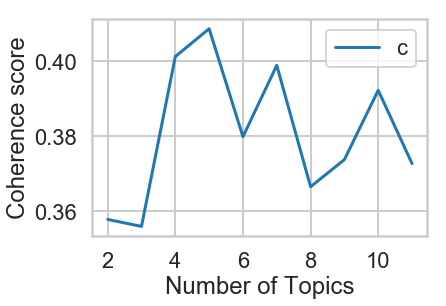

In [22]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

Now, we will build another model with 5 topics as shown by the coherence values.

In [23]:
# LSA Model
number_of_topics=5
words=10
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.292*"food" + 0.237*"good" + 0.235*"order" + 0.230*"place" + 0.188*"like" + 0.172*"time" + 0.162*"get" + 0.148*"go" + 0.143*"one" + 0.134*"servic"'), (1, '-0.513*"order" + 0.321*"good" + 0.307*"place" + 0.261*"great" + 0.254*"food" + -0.206*"us" + -0.144*"ask" + -0.137*"wait" + -0.134*"minut" + -0.132*"tabl"'), (2, '0.623*"food" + -0.238*"good" + -0.213*"like" + 0.209*"servic" + -0.177*"chicken" + -0.160*"sauc" + 0.140*"great" + 0.139*"us" + -0.116*"flavor" + -0.111*"order"'), (3, '0.444*"food" + 0.428*"order" + -0.302*"place" + 0.277*"chicken" + 0.229*"good" + -0.217*"get" + -0.140*"go" + 0.121*"dish" + -0.112*"time" + 0.112*"sauc"'), (4, '-0.561*"place" + -0.432*"order" + 0.279*"restaur" + 0.184*"us" + -0.176*"time" + -0.163*"good" + 0.139*"menu" + 0.128*"tabl" + -0.124*"get" + 0.107*"great"')]


<b>Analysis</b> <br>
Based on above topic recognition, we identify 5 topics, however they were overlapping or unclear. <br>

As a next step, we will try lemmatization to check whether it returns better results. <br>
Lemmatization will make sure the lemmas are actual english words. <br>

## Lemmatization and LSA Model

In [45]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [46]:
## Lemmatize Data
def lemmatize_set(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    # p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        lemmatized_tokens = [wordnet_lemmatizer.lemmatize(i, pos="v") for i in stopped_tokens]
        # add tokens to list
        texts.append(lemmatized_tokens)
    return texts

In [47]:
clean_lematized_text=lemmatize_set(document_list)

In [50]:
clean_lematized_text[0]

['go',
 'lunch',
 'steak',
 'sandwich',
 'delicious',
 'caesar',
 'salad',
 'absolutely',
 'delicious',
 'dress',
 'perfect',
 'amount',
 'dress',
 'distribute',
 'perfectly',
 'across',
 'leaf',
 'know',
 'go',
 'salad',
 'perfect',
 'drink',
 'price',
 'pretty',
 'good',
 'server',
 'dawn',
 'friendly',
 'accommodate',
 'happy',
 'summation',
 'great',
 'pub',
 'experience',
 'would',
 'go']

In [51]:
all_lemmatized_tokens=[]
for i in range(len(clean_lematized_text)):
    for j in range(len(clean_lematized_text[i])):
        all_lemmatized_tokens.append(clean_lematized_text[i][j])

## Finding the top 20 and bottom 20 lemmas from the reviews

In [56]:
top_20_lemmatized_tokens = Counter(all_lemmatized_tokens).most_common(20)
print(top_20_lemmatized_tokens)

[('food', 3669), ('place', 3074), ('good', 2950), ('get', 2836), ('go', 2514), ('order', 2383), ('great', 2229), ('time', 2020), ('come', 2006), ('like', 1986), ('service', 1921), ('one', 1508), ('try', 1472), ('make', 1450), ('back', 1446), ('really', 1340), ('would', 1316), ('love', 1167), ('also', 1101), ('eat', 1087)]


In [54]:
least_common_values(all_lemmatized_tokens,20)

[('tavolta', 1),
 ('outnumber', 1),
 ('romano', 1),
 ('gentler', 1),
 ('teen', 1),
 ('smdh', 1),
 ('92', 1),
 ('bside', 1),
 ('tika', 1),
 ('gnomes', 1),
 ('smurfs', 1),
 ('molotov', 1),
 ('poland', 1),
 ('hungarian', 1),
 ('softness', 1),
 ('internationally', 1),
 ('pettuccine', 1),
 ('piccata', 1),
 ('raku', 1),
 ('gi', 1)]

In [68]:
# Side by side comparison
print("{0:20}{1:20}{2:20}{3:20}".format("Stemming","Frequency","Lemmatization", "Frequency"))
for i in range(20):
    print("{0:20}{1:20}{2:20}{3:20}".format(top_20_stemmed_tokens[i][0], str(top_20_stemmed_tokens[i][1])
                                , top_20_lemmatized_tokens[i][0], str(top_20_lemmatized_tokens[i][1])))

Stemming            Frequency           Lemmatization       Frequency           
food                3716                food                3669                
place               3074                place               3074                
good                2998                good                2950                
order               2383                get                 2836                
great               2233                go                  2514                
time                2034                order               2383                
like                2016                great               2229                
servic              1921                time                2020                
get                 1775                come                2006                
go                  1750                like                1986                
one                 1602                service             1921                
tri                 1476    

In [69]:
print ('went' in all_lemmatized_tokens)

False


In [70]:
print ('went' in all_stemmed_tokens)

True


<b> Analysis </b> <br>
1. The lemmas are better readable compared with the stems. Example: servic vs service, tri vs try, realli vs really <br>
2. Lemmatization considered part of speech, Hence, it stores the main lemma associated with each words. Example: Frequency of lemma 'get' is higher than the stem 'get' because the lemma considers all words irrespective of part of speech.  <br>


## LSA Model

In [71]:
# LSA Model
number_of_topics=6
words=10
model=create_gensim_lsa_model(clean_lematized_text,number_of_topics,words)

[(0, '0.276*"food" + 0.261*"get" + 0.228*"order" + 0.223*"good" + 0.221*"place" + 0.211*"go" + 0.181*"come" + 0.178*"like" + 0.166*"time" + 0.130*"one"'), (1, '-0.407*"order" + 0.336*"good" + 0.301*"place" + 0.300*"food" + 0.272*"great" + -0.237*"get" + -0.190*"us" + -0.169*"take" + -0.167*"say" + -0.134*"ask"'), (2, '-0.651*"food" + 0.226*"like" + 0.224*"good" + -0.223*"service" + 0.174*"get" + -0.146*"us" + 0.144*"chicken" + -0.142*"great" + 0.138*"sauce" + -0.113*"come"'), (3, '0.525*"order" + -0.394*"get" + -0.280*"place" + -0.271*"go" + 0.268*"chicken" + 0.226*"food" + 0.169*"good" + 0.144*"sauce" + 0.144*"dish" + 0.128*"fry"'), (4, '0.482*"get" + 0.446*"good" + -0.325*"great" + 0.277*"food" + -0.161*"come" + 0.148*"order" + -0.148*"us" + -0.134*"menu" + -0.134*"restaurant" + -0.130*"make"'), (5, '0.547*"place" + 0.493*"order" + -0.262*"good" + 0.198*"great" + -0.184*"like" + 0.161*"time" + -0.155*"us" + -0.115*"would" + -0.114*"restaurant" + 0.111*"love"')]


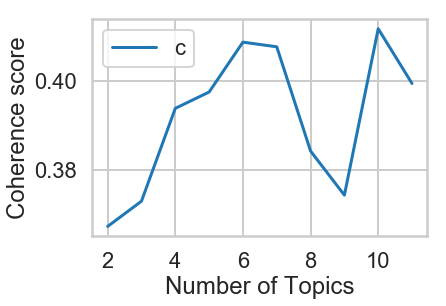

In [72]:
start,stop,step=2,12,1
plot_graph(clean_lematized_text,start,stop,step)

In [74]:
# LSA Model
number_of_topics=6
words=5
model=create_gensim_lsa_model(clean_lematized_text,number_of_topics,words)

[(0, '0.276*"food" + 0.261*"get" + 0.228*"order" + 0.223*"good" + 0.221*"place"'), (1, '-0.407*"order" + 0.336*"good" + 0.301*"place" + 0.299*"food" + 0.272*"great"'), (2, '-0.651*"food" + 0.225*"like" + 0.224*"good" + -0.224*"service" + 0.174*"get"'), (3, '0.525*"order" + -0.394*"get" + -0.280*"place" + -0.271*"go" + 0.267*"chicken"'), (4, '-0.482*"get" + -0.446*"good" + 0.324*"great" + -0.277*"food" + 0.161*"come"'), (5, '-0.546*"place" + -0.494*"order" + 0.264*"good" + -0.199*"great" + 0.183*"like"')]


## TF-IDF

In [76]:
dictionary_lemas, doc_term_matrix_lemas  = prepare_corpus(clean_lematized_text)

# Sample Format
# Dictionary(13918 unique tokens: ['absolutely', 'accommodate', 'across', 'amount', 'caesar']...)
# doc_term_matrix_lemas (word and how many documents it appears)
# [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), 
# (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), 
# (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)],

In [81]:
gc.collect()

2158

In [82]:
from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(doc_term_matrix_lemas)

In [ ]:
tfidf_weights = tfidf[doc]